# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_breeds = np.array(data['target'])
    return dog_files, dog_breeds

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))
print(train_targets)
print(train_files)

There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.
[94 56 87 ..., 28 45 47]
['dogImages/train/095.Kuvasz/Kuvasz_06442.jpg'
 'dogImages/train/057.Dalmatian/Dalmatian_04054.jpg'
 'dogImages/train/088.Irish_water_spaniel/Irish_water_spaniel_06014.jpg'
 ..., 'dogImages/train/029.Border_collie/Border_collie_02069.jpg'
 'dogImages/train/046.Cavalier_king_charles_spaniel/Cavalier_king_charles_spaniel_03261.jpg'
 'dogImages/train/048.Chihuahua/Chihuahua_03416.jpg']


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


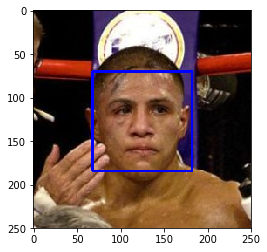

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
- **99%** of human faces have been detected correctly
- **11%** of dog faces have been detected as human face

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
import functools

percent_dog_faces_detected = len(list(
    filter(lambda dog_file: face_detector(dog_file), dog_files_short))) / len(dog_files_short)
percent_human_faces_detected = len(list(
    filter(lambda human_file: face_detector(human_file), human_files_short))) / len(human_files_short)

print('Percent of dog faces detected: {}'.format(percent_dog_faces_detected))
print('Percent of human faces detected: {}'.format(percent_human_faces_detected))

Percent of dog faces detected: 0.11
Percent of human faces detected: 0.98


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

#### Load pretrained models for PyTorch

In [6]:
import torchvision.models

resnet50_model= torchvision.models.resnet50(pretrained=True).cuda()
vgg16_model= torchvision.models.vgg16(pretrained=True).cuda()

#### Create single image loader

In [7]:
import torch
from torchvision import datasets, models, transforms
from torch.autograd import Variable
from PIL import Image

imsize = 224, 224

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225])

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor(),
    normalize])

def image_loader(img_path):
    image = Image.open(img_path)
    image = loader(image).float()
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

#### Load predict function (use VGG16 model)

In [8]:
def vgg16_predict_labels(img_path):
    image = image_loader(img_path)
    outputs = vgg16_model(image)
    _, pred_idx = torch.max(outputs.data, 1)
    return pred_idx[0]

#### Dog detector function  
Return 1 if dog is detected, 0 - otherwise. Dog breeds are classes from 151 to 268 in the ImageNet data set. 

In [9]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = vgg16_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

#### Test the dog detector on dog and human faces

In [10]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
import functools

percent_dog_faces_detected = len(list(
    filter(lambda dog_file: dog_detector(dog_file), dog_files_short))) / len(dog_files_short)
percent_human_faces_detected = len(list(
    filter(lambda human_file: dog_detector(human_file), human_files_short))) / len(human_files_short)

print('Percent of dog faces detected: {}'.format(percent_dog_faces_detected))
print('Percent of human faces detected: {}'.format(percent_human_faces_detected))

Percent of dog faces detected: 0.98
Percent of human faces detected: 0.0


### Step 3: Dog data set and loader

#### Dog dataset to provide images and their labels

In [11]:
from torch.utils.data import Dataset, DataLoader

class DogDataset(Dataset):
    def __init__(self, image_files, targets, transform=None):
        self.image_files = image_files
        self.targets = targets
        self.transform = transform
        
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_files[idx])
        if self.transform:
            image = self.transform(image)
        targets = self.targets[idx]
        return [image, targets]

#### Loader of images and labels

In [12]:
imsize = 224

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225])

transform_ds = transforms.Compose([
    transforms.Resize(imsize),
    transforms.CenterCrop(imsize),
    transforms.ToTensor(),
    normalize])

train_ds = DogDataset(train_files, train_targets, transform=transform_ds)
test_ds = DogDataset(test_files, test_targets, transform=transform_ds)
valid_ds = DogDataset(valid_files, valid_targets, transform=transform_ds)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=True, num_workers=4)

#### Short test of the interplay between data set, data loader and model

In [13]:
inputs, targets = next(iter(test_loader))

inputs = Variable(inputs).cuda()
targets = Variable(targets).cuda()

outputs = resnet50_model(inputs)
_, pred_idx = torch.max(outputs.data, 1)
print(pred_idx)
print(targets.data)


 251
 236
 157
 181
 205
 224
 227
 216
 189
 260
 160
 181
 185
 187
 235
 253
[torch.cuda.LongTensor of size 16 (GPU 0)]


  56
  58
 114
  18
  67
  20
  42
  51
  96
  50
   1
  18
  74
 132
  70
  13
[torch.cuda.LongTensor of size 16 (GPU 0)]



### Step 4: Replace the last layer of ResNet50 model and train

#### Save checkpoint function

In [14]:
import shutil
import os

checkpoints_dir = './checkpoints/'

def prepare_checkpoints_dir():
    # clear checkpoints directory
    if os.path.exists(checkpoints_dir):
        shutil.rmtree(checkpoints_dir)
    os.makedirs(checkpoints_dir)

# save checkpoint function
def save_checkpoint(model, is_best, filename='checkpoint.pth.tar'):
    filepath = checkpoints_dir + filename
    torch.save(model.state_dict(), filepath)
    if is_best:
        best_filepath = checkpoints_dir + 'model_best.pth.tar'
        shutil.copyfile(filepath, best_filepath)

#### Train function

In [15]:
def train_epoch(model, epoch, loader, criterion, optimizer):
    dataset_size = len(loader.dataset)
    running_loss = 0.0
    running_correct = 0
    log_after = 20
    batch_counter = 0
    
    model.train()
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs_var = Variable(inputs).cuda()
        targets_var = Variable(targets).cuda()

        optimizer.zero_grad()
        outputs = model(inputs_var)
        _, pred_idx = torch.max(outputs.data, 1)

        loss = criterion(outputs, targets_var)
        loss.backward()
        optimizer.step()

        if (batch_counter % log_after) == 0:
            print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), 
                dataset_size, loss.data[0]))
        running_loss += loss.data[0]
        running_correct += torch.sum(pred_idx == targets_var.data)
        batch_counter += 1
    
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_correct / dataset_size
    
    return (epoch_loss, epoch_acc)

In [16]:
def test_epoch(model, epoch, loader):
    dataset_size = len(loader.dataset)
    running_loss = 0.0
    running_correct = 0
    log_after = 10
    batch_counter = 0
    
    model.eval()
    for batch_idx, (inputs, targets) in enumerate(loader):
        inputs_var = Variable(inputs).cuda()
        targets_var = Variable(targets).cuda()

        outputs = model(inputs_var)
        _, pred_idx = torch.max(outputs.data, 1)
        loss = criterion(outputs, targets_var)

        if (batch_counter % log_after) == 0:
            print('Test Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), 
                dataset_size, loss.data[0]))
        
        running_loss += loss.data[0]
        running_correct += torch.sum(pred_idx == targets_var.data)
        batch_counter += 1
        
    epoch_loss = running_loss / dataset_size
    epoch_acc = running_correct / dataset_size
    
    return (epoch_loss, epoch_acc)

In [17]:
def train(model, train_loader, valid_loader, criterion, optimizer, epochs=10):   
    best_model_wts = model.state_dict()
    best_acc = 0.0
    best_loss = 1000.0
    
    for epoch in range(1, epochs + 1):
        train_epoch_loss, train_epoch_acc = train_epoch(model, epoch, train_loader, criterion, optimizer)
        valid_epoch_loss, valid_epoch_acc = test_epoch(model, epoch, valid_loader)
            
        is_best = False
        if valid_epoch_acc > best_acc:
            best_acc = valid_epoch_acc
            best_loss = valid_epoch_loss
            best_model_wts = model.state_dict()
            is_best = True
            
        save_checkpoint(model, is_best)
        
        print('Epoch [{}/{}]\ttrain loss: {:.4f}\ttrain acc: {:.4f}\tvalid loss: {:.4f}\tvalid acc: {:.4f}'.format(
                epoch, epochs,
                train_epoch_loss, train_epoch_acc, 
                valid_epoch_loss, valid_epoch_acc))
            
    print('Best validation accuracy: {:6f}\tBest validation loss: {:6f}'.format(best_acc, best_loss))

    model.load_state_dict(best_model_wts)
    return model

#### Replace the last layer and train

In [18]:
resnet50_model= torchvision.models.resnet50(pretrained=True).cuda()

# freeze all model parameters
for param in resnet50_model.parameters():
    param.requires_grad = False
    
# new final layer with 133 classes
num_features = resnet50_model.fc.in_features
resnet50_model.fc = torch.nn.Linear(num_features, len(dog_names))
resnet50_model = resnet50_model.cuda()

criterion = torch.nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(resnet50_model.fc.parameters(), lr = 0.001)

In [19]:
# avoid the PIL error "OSError: image file is truncated (150 bytes not processed)"
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

best_model_checkpoint = checkpoints_dir + 'model_best.pth.tar'
if os.path.exists(best_model_checkpoint):
    final_model = resnet50_model
    final_model.load_state_dict(torch.load(best_model_checkpoint))
else:
    prepare_checkpoints_dir()
    final_model = train(resnet50_model, train_loader, valid_loader, criterion, optimizer, epochs=10)

Train Epoch: 1 [0/6680]	Loss: 4.995574
Train Epoch: 1 [1280/6680]	Loss: 3.282723
Train Epoch: 1 [2560/6680]	Loss: 2.350372
Train Epoch: 1 [3840/6680]	Loss: 1.236653
Train Epoch: 1 [5120/6680]	Loss: 1.294232
Train Epoch: 1 [6400/6680]	Loss: 1.036624
Test Epoch: 1 [0/835]	Loss: 1.007078
Test Epoch: 1 [640/835]	Loss: 0.885029
Epoch [1/10]	train loss: 0.0347	train acc: 0.5608	valid loss: 0.0146	valid acc: 0.7952
Train Epoch: 2 [0/6680]	Loss: 0.587613
Train Epoch: 2 [1280/6680]	Loss: 0.760448
Train Epoch: 2 [2560/6680]	Loss: 0.722669
Train Epoch: 2 [3840/6680]	Loss: 0.545451
Train Epoch: 2 [5120/6680]	Loss: 0.486366
Train Epoch: 2 [6400/6680]	Loss: 0.576820
Test Epoch: 2 [0/835]	Loss: 0.775459
Test Epoch: 2 [640/835]	Loss: 0.582709
Epoch [2/10]	train loss: 0.0099	train acc: 0.8539	valid loss: 0.0108	valid acc: 0.8419
Train Epoch: 3 [0/6680]	Loss: 0.393631
Train Epoch: 3 [1280/6680]	Loss: 0.317392
Train Epoch: 3 [2560/6680]	Loss: 0.394798
Train Epoch: 3 [3840/6680]	Loss: 0.443229
Train Epoch

### Step 5: Test the model

In [20]:
def predict_breed(img_path):
    image = image_loader(img_path)
    
    outputs = final_model(image)
    _, pred_idx = torch.max(outputs.data, 1)
    
    return dog_names[pred_idx[0]]

#### Test model on test data

In [21]:
correct = 0

final_model.eval() # <- this must be called for resnet before prediction bacause it uses batch norm.
for inputs, targets in test_loader:
    inputs_var = Variable(inputs).cuda()
    targets_var = Variable(targets).cuda()

    outputs = final_model(inputs_var)
    _, pred_idx = torch.max(outputs.data, 1)

    correct += torch.sum(pred_idx == targets_var.data)

accuracy = correct / len(test_loader.dataset)
print('Test accuracy: {:6f}'.format(accuracy))

Test accuracy: 0.870813


#### Test prediction on some pictures

In [22]:
def make_prediction(img_path):
    '''
    Detects a dog or a human in the image. If a dog has been detected
    then predicts its breed
    
    :param image_path: Path to a file with an image. The image of an arbitrary size.
    '''
    # detect dog or human and the breed
    dog_detected = dog_detector(img_path)
    human_detected = face_detector(img_path)
    
    if not dog_detected and not human_detected:
        text_for_image = '!!!I COULD NOT FIND ANY SPECIES IN THE IMAGE!!!'
    else:
        breed = predict_breed(img_path)
        if dog_detected:
            text_for_image = 'Hello dog! I think you are a {}'.format(breed)
        else:
            text_for_image = 'Hello human! I found you look like {}'.format(breed)

    # prepare the image for drawing
    img = cv2.imread(img_path)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # plot the image and a title
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(rgb)
    ax.set_title(text_for_image)

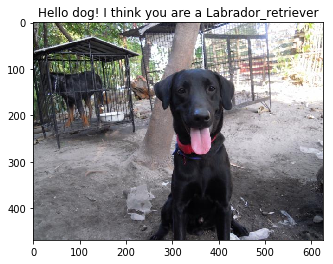

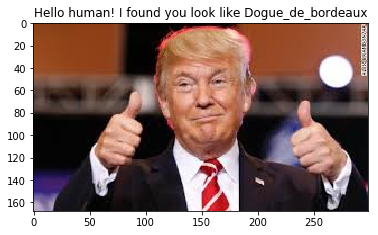

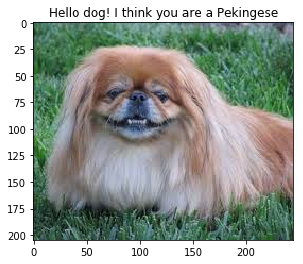

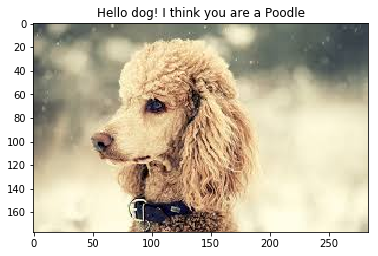

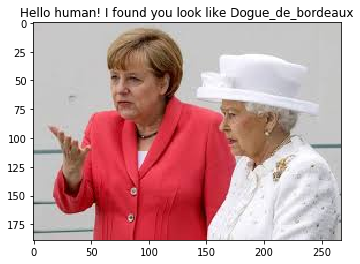

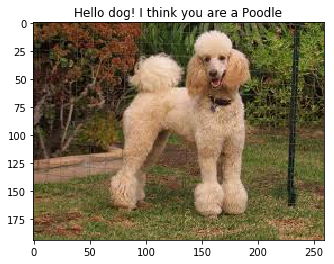

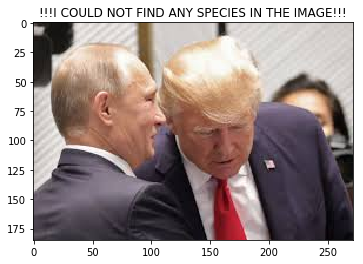

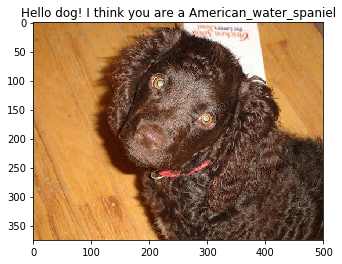

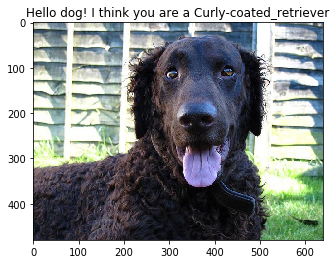

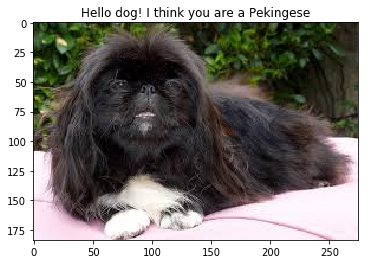

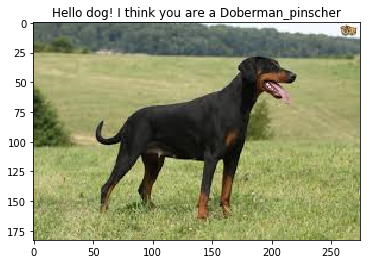

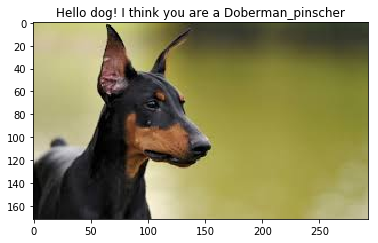

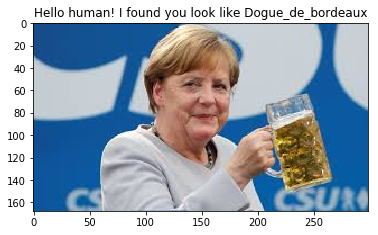

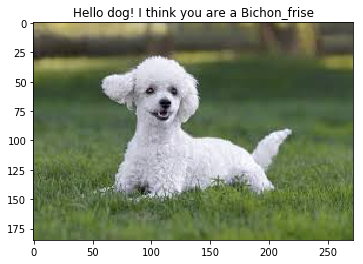

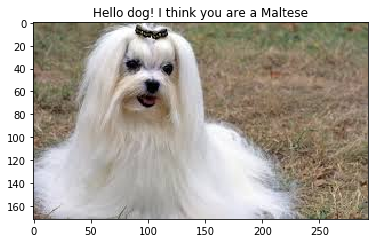

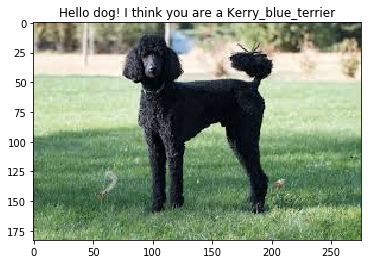

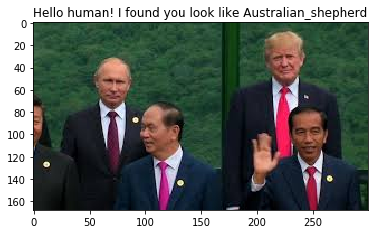

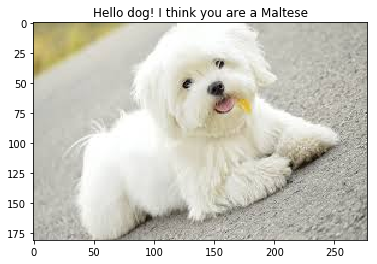

In [23]:
sample_images_dir = "./sample_images/"

final_model.eval() # <- this must be called for resnet before prediction bacause it uses batch norm.
for image_file in os.listdir(sample_images_dir):
    make_prediction(sample_images_dir + image_file)